In [1]:
!nvidia-smi

Sun Mar  7 06:50:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Let's install some modules

import gdown
!pip install tensorflow_text
import wordcloud
!pip install tensorflow-gpu

     |████████████████████████████████| 3.4MB 20.3MB/s 
     |████████████████████████████████| 394.3MB 41kB/s 


In [3]:
# Let's load the weapons !

import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
# Just to check whether Battleground is empty or not ( available or not )
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
# Lets have look at enemy  ( Downloading data )


!gdown --id 1e1SsVct7B6m3GLKlYKHb4ZGy8Ws4K35r --output 515k-hotel-reviews-data-in-europe.zip

Downloading...
From: https://drive.google.com/uc?id=1e1SsVct7B6m3GLKlYKHb4ZGy8Ws4K35r
To: /content/515k-hotel-reviews-data-in-europe.zip
47.3MB [00:00, 71.1MB/s]


In [6]:
!unzip -q 515k-hotel-reviews-data-in-europe.zip


In [7]:
!ls

515k-hotel-reviews-data-in-europe.zip  Hotel_Reviews.csv  sample_data


In [8]:
# Talks failes , left with the warrr , let's use our weapons one by one

df=pd.read_csv("Hotel_Reviews.csv",parse_dates=["Review_Date"])

In [10]:
# Let's look at enemy strengths , so far we need to consider Reviews ( as this is our title ) and 

df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-24,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [11]:
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [12]:
# we need to worry about reviews it can be either positive or negative , so lets club them 

# And !!! , consider "bad" when review_score is less than 7 else "good" , why 7 ? , with minimum 7 threshold we are getting enough training data 

# Feel free to look at the review score to understand more

df['review']=df['Negative_Review']+df['Positive_Review']
df['review_type']=df['Reviewer_Score'].apply(
    lambda x: "bad" if x<7 else "good"
)

In [15]:
df['review_type'].value_counts()

# Warning :  Imbalance Data !!!!

good    428887
bad      86851
Name: review_type, dtype: int64

In [16]:
# As said earlier we are going to consider Reviewer and Review_type , so drop others

df=df[['review','review_type']]

Text(0.5, 0, 'Type')

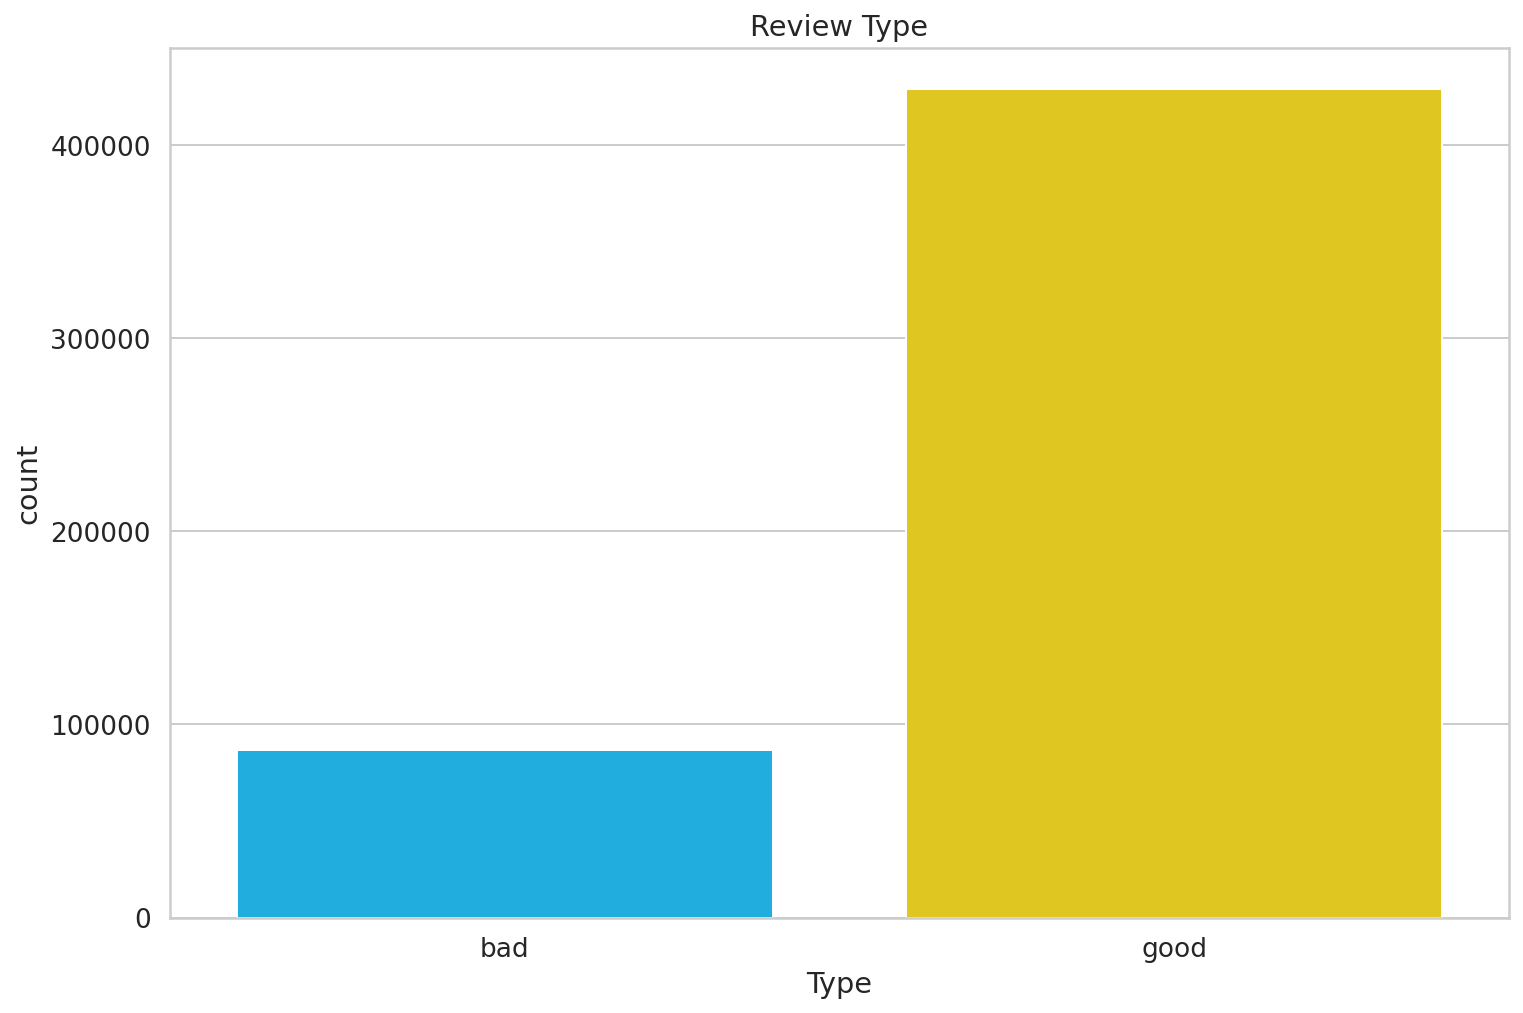

In [ ]:
# look at imabalance data , 

sns.countplot(
    x='review_type',
    data=df,

)
plt.title("Review Type")
plt.xlabel("Type")

you can see that there are lot of good reviews than bad reviews , so lets try to solve this imbalance issue 

In [17]:
# There are lot of ways to treat imbalance data but here we are making both types of equal size 


good_reviews=df[df.review_type=="good"]
bad_reviews=df[df.review_type=='bad']

In [18]:
good_reviews.head()

,review,review_type
1,No Negative No real complaints the hotel was g...,good
2,Rooms are nice but for elderly a bit difficul...,good
7,Apart from the price for the brekfast Everyth...,good
9,The aircondition makes so much noise and its ...,good
10,Nothing all great Rooms were stunningly deco...,good


In [23]:
# Here we just grouping the all the good text into single string , this is to show you the wordcloud 


good_reviews_text=" ".join(good_reviews.review.to_numpy().tolist())
bad_reviews_text=" ".join(bad_reviews.review.to_numpy().tolist())

In [24]:
# Let's see our good reviews string looks like 

good_reviews_text[0:1000]

'No Negative No real complaints the hotel was great great location surroundings rooms amenities and service Two recommendations however firstly the staff upon check in are very confusing regarding deposit payments and the staff offer you upon checkout to refund your original payment and you can make a new one Bit confusing Secondly the on site restaurant is a bit lacking very well thought out and excellent quality food for anyone of a vegetarian or vegan background but even a wrap or toasted sandwich option would be great Aside from those minor minor things fantastic spot and will be back when i return to Amsterdam   Rooms are nice but for elderly a bit difficult as most rooms are two story with narrow steps So ask for single level Inside the rooms are very very basic just tea coffee and boiler and no bar empty fridge  Location was good and staff were ok It is cute hotel the breakfast range is nice Will go back   Apart from the price for the brekfast Everything very good Good location 

'No Ne'

To get most common words and show it in nice image format we use WordCLoud ( this much i know while writing this one )

In [25]:
# Code is pretty much self explanatory 

good_reviews_cloud=WordCloud(stopwords=STOPWORDS,background_color="white").generate(good_reviews_text)
bad_reviews_cloud=WordCloud(stopwords=STOPWORDS,background_color="white").generate(bad_reviews_text)

In [26]:
# This function is just to show you the images created by WordCloud

def show_cloud(cloud,title):
  plt.figure(figsize=(16,10))
  plt.title(title)
  plt.imshow(cloud,interpolation="bilinear")
  plt.axis("off")
  

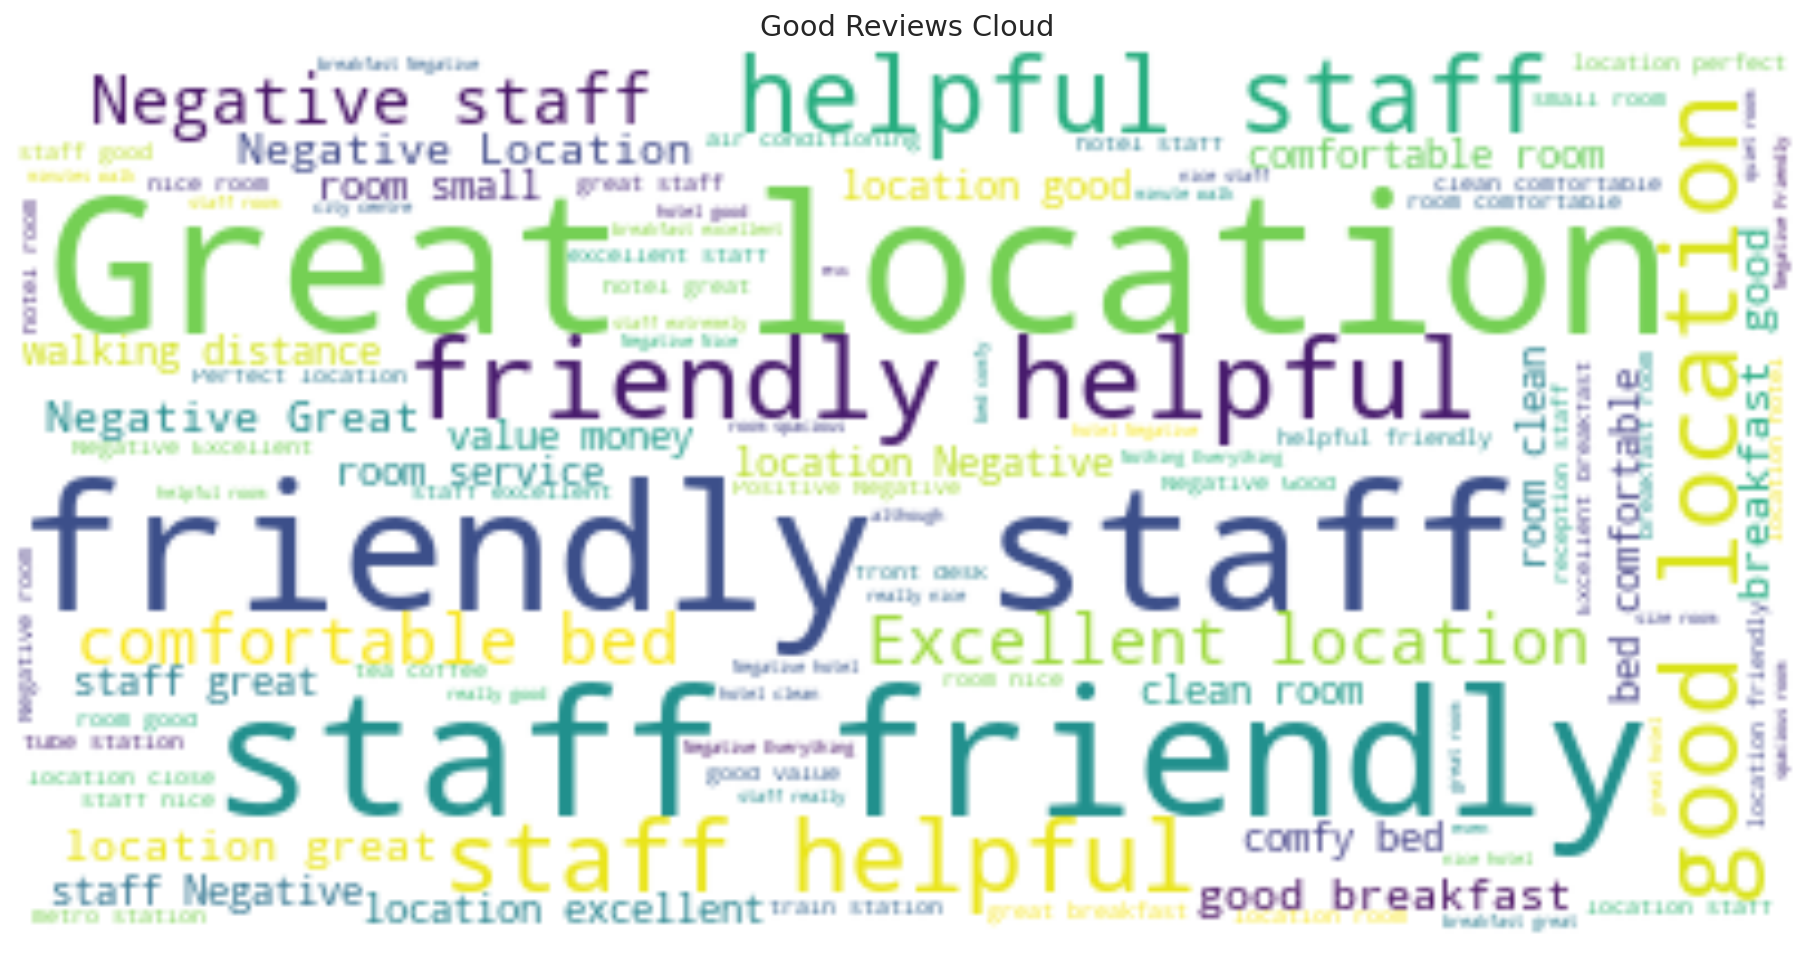

In [27]:
show_cloud(good_reviews_cloud,"Good Reviews Cloud")

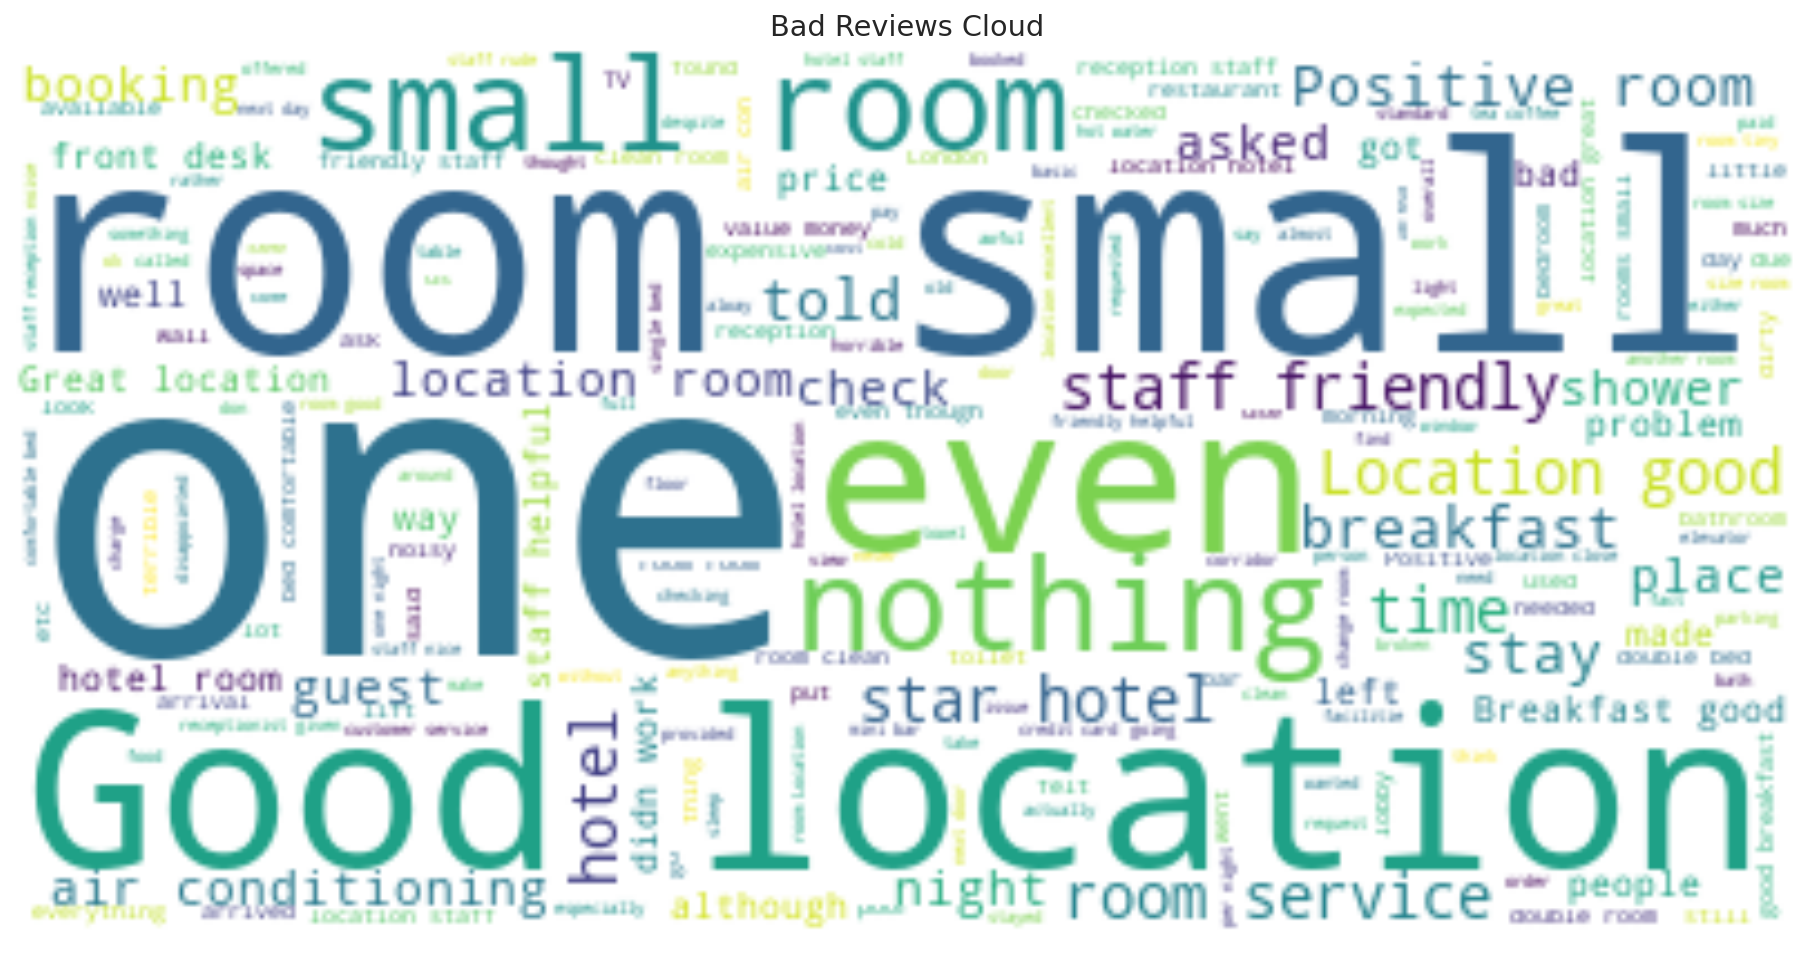

In [28]:
show_cloud(bad_reviews_cloud,"Bad Reviews Cloud")

In [29]:
# Now lets come back to our Imbalance data 

# here we are taking good reviews data as much as bad reviews data

good_df=good_reviews.sample(n=len(bad_reviews),random_state=RANDOM_SEED)
bad_df=bad_reviews
print(good_df.shape)
print(bad_df.shape)

(86851, 2)
(86851, 2)


In [30]:
good_df.head()

,review,review_type
504253,Nothing not to like Location was excellent r...,good
93126,Replenishment of supplies in room toiletries ...,good
276636,No Negative The views,good
141189,Could do with biscuits and a complimentary wa...,good
199301,Bar prices expensive and mini bar very expens...,good


In [32]:
# Let's append

review_df=good_df.append(bad_df).reset_index(drop=True)
review_df.shape

(173702, 2)

In [33]:
review_df.head()

,review,review_type
0,Nothing not to like Location was excellent r...,good
1,Replenishment of supplies in room toiletries ...,good
2,No Negative The views,good
3,Could do with biscuits and a complimentary wa...,good
4,Bar prices expensive and mini bar very expens...,good


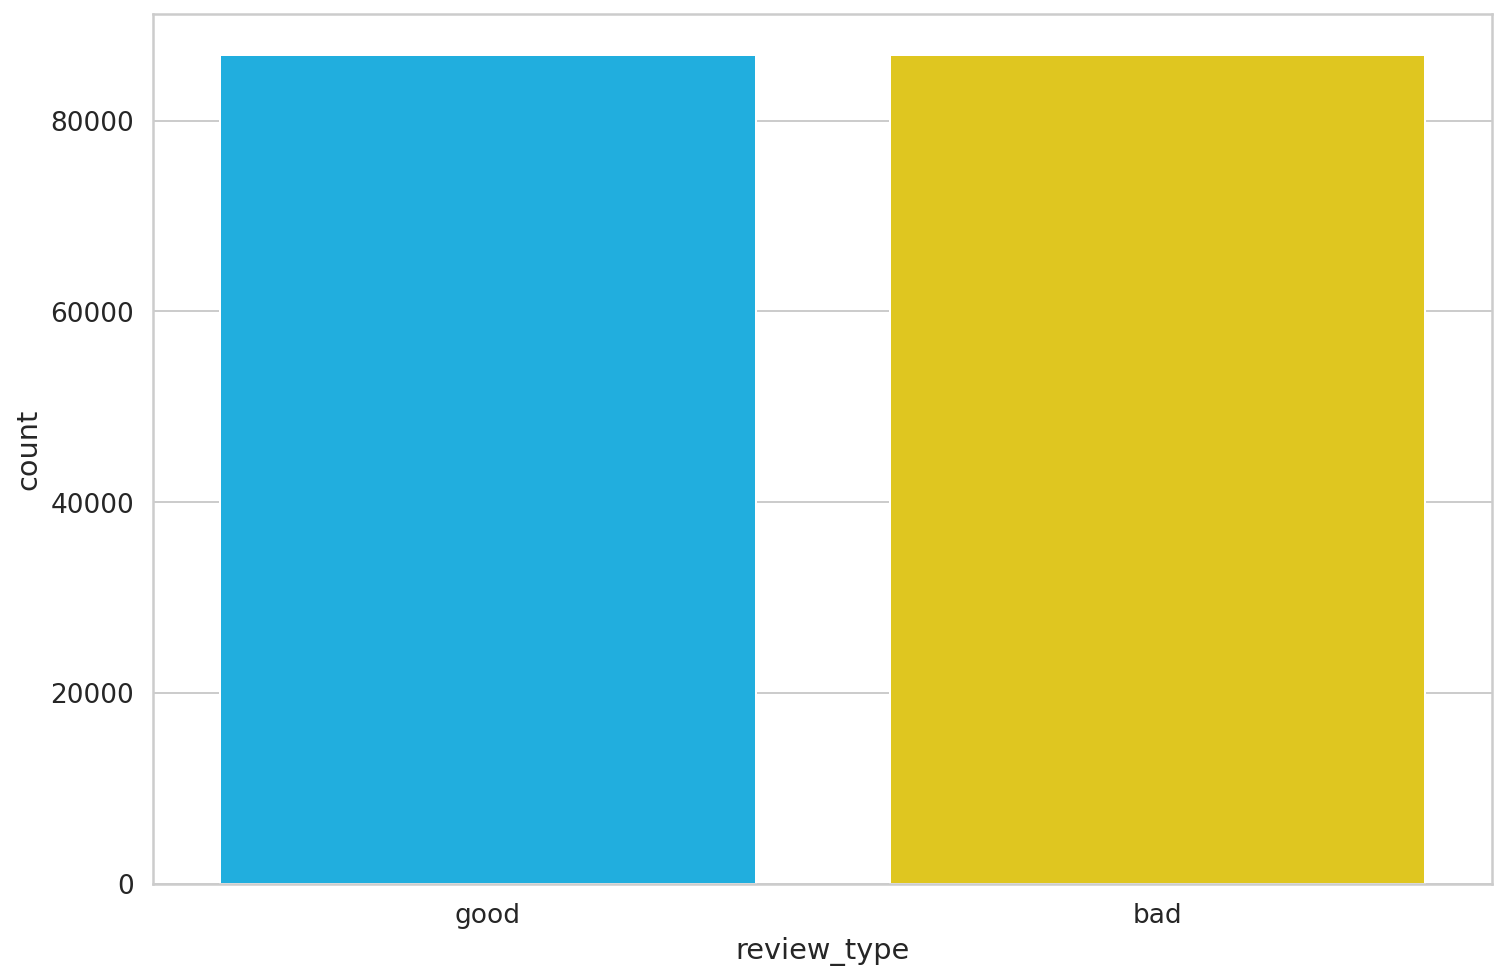

In [34]:
sns.countplot(
    x="review_type",
    data=review_df
)

In [35]:
# Here is our Powerfull Weapon , Universal Sentence Encoder version 3 


use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [36]:
# if you are not familiar with USE , then lets have look at below examples so that you know what USE does to review string 

sent_1="this is a great review"
sent_2="amazing review"

s1=use(sent_1)
s2=use(sent_2)

USE creates a vector of 512 size ( embedding vector ) ,if you dont know what is embedding vector please stop and read about it and come back

In [37]:
print(s1.shape)
print(s2.shape)



(1, 512)
(1, 512)


In [39]:
# How we are going to get similarity between those two seneteces 

# Here we are using Cosine Similarity ( its famous one ) , we have other ways like Euclidean Distance , Word Mover's Distance

from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(s1,s2)

array([[0.6842507]], dtype=float32)

# Text Preprocessing

In [45]:
from sklearn.preprocessing import OneHotEncoder

In [50]:
# We are converting Good or Bad review type to binary 

type_one_hot=OneHotEncoder(sparse=False).fit_transform(
    review_df.review_type.to_numpy().reshape(-1,1)
)

In [51]:
review_df.iloc[0][0]

' Nothing not to like  Location was excellent rooms were extremely comfortable well maintained Facilities within the hotel were great especially the lounge which was a perfect place to relax after a day of sightseeing '

In [52]:
review_df.iloc[0][1]

'good'

In [53]:

type_one_hot[0]

array([0., 1.])

In [54]:
train_reviews,test_reviews,train_type,test_type=train_test_split(
    review_df.review,
    type_one_hot,
    test_size=.1,
    random_state=RANDOM_SEED
    
)

In [55]:
X_train = []

# tqdm , this is just like a for loop but it has feature of progress bars , well what is the use of progress bars 
##  1-) You get a reliable estimate of how long it will take
##  2-) You can see immediately if it’s gotten stuck

# Here we are mainly converting normal review string to embedded one with requires shape 


for r in tqdm(train_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)


100%|██████████| 156331/156331 [31:22<00:00, 83.05it/s]


In [56]:
# Let's lok at the last one 

review_emb

array([-2.67558657e-02, -1.53677156e-02, -5.50255924e-03, -1.27076553e-02,
        1.23840064e-01, -1.85448360e-02, -7.06327409e-02, -5.46652228e-02,
        1.73472648e-03,  3.03555094e-02, -5.74329831e-02,  6.58882186e-02,
        2.15688441e-02, -1.64459664e-02,  2.41735508e-03,  3.00920028e-02,
       -2.25970186e-02,  3.60077955e-02,  1.78483073e-02,  1.33960797e-02,
        4.09364104e-02,  6.04037680e-02, -3.78300808e-02,  4.21857983e-02,
       -1.70328061e-03,  5.29529676e-02, -1.77369509e-02,  5.38507178e-02,
        3.05623095e-02, -8.20134301e-03,  2.53744870e-02, -5.64583726e-02,
        4.44374606e-02, -5.09428829e-02,  8.14024452e-03,  2.12248806e-02,
       -9.12318192e-03,  7.00119212e-02, -3.43187526e-02, -2.60607228e-02,
        1.45530179e-02,  5.92783727e-02,  3.20384800e-02,  8.96985456e-03,
       -7.84030706e-02, -3.07935495e-02,  3.01824673e-03,  5.28366826e-02,
       -1.84906852e-02, -1.88040156e-02,  1.11301728e-02, -6.90946206e-02,
       -5.71891330e-02,  

In [57]:
# Do the same thing for test reviews also

X_test = []
for r in tqdm(test_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 17371/17371 [03:27<00:00, 83.57it/s]


In [58]:
model=keras.Sequential()


In [59]:
model.add(
    keras.layers.Dense(
        units=256,
        input_shape=[X_train.shape[1],],
        activation="relu"
    )
)

model.add(
    keras.layers.Dropout(
        rate=0.5
    )
)

model.add(
    keras.layers.Dense(
        units=128,
        activation="relu"
    )
)

model.add(
    keras.layers.Dropout(
        rate=0.5
    )
)

model.add(
    keras.layers.Dense(
        2,
        activation="softmax"
    )
)

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [60]:
history=model.fit(
    X_train,train_type,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=True

)

Epoch 1/10
8794/8794 [==============================] - 21s 2ms/step - loss: 0.4563 - accuracy: 0.7835 - val_loss: 0.4030 - val_accuracy: 0.8131
Epoch 2/10
8794/8794 [==============================] - 21s 2ms/step - loss: 0.4131 - accuracy: 0.8094 - val_loss: 0.3931 - val_accuracy: 0.8170
Epoch 3/10
8794/8794 [==============================] - 21s 2ms/step - loss: 0.4045 - accuracy: 0.8157 - val_loss: 0.3915 - val_accuracy: 0.8176
Epoch 4/10
8794/8794 [==============================] - 21s 2ms/step - loss: 0.3965 - accuracy: 0.8187 - val_loss: 0.3886 - val_accuracy: 0.8209
Epoch 5/10
8794/8794 [==============================] - 21s 2ms/step - loss: 0.3895 - accuracy: 0.8232 - val_loss: 0.3901 - val_accuracy: 0.8208
Epoch 6/10
8794/8794 [==============================] - 21s 2ms/step - loss: 0.3843 - accuracy: 0.8272 - val_loss: 0.3848 - val_accuracy: 0.8231
Epoch 7/10
8794/8794 [==============================] - 21s 2ms/step - loss: 0.3791 - accuracy: 0.8289 - val_loss: 0.3839 - val_ac

In [61]:
score = model.evaluate(X_test, test_type, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.3974740207195282 / Test accuracy: 0.8179724812507629


In [62]:
# Lets try out with EPOCHS= 20

In [64]:
history=model.fit(
    X_train,train_type,
    epochs=20,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=True

)

Epoch 1/20
8794/8794 [==============================] - 21s 2ms/step - loss: 0.3625 - accuracy: 0.8383 - val_loss: 0.3825 - val_accuracy: 0.8240
Epoch 2/20
8794/8794 [==============================] - 21s 2ms/step - loss: 0.3594 - accuracy: 0.8408 - val_loss: 0.3819 - val_accuracy: 0.8254
Epoch 3/20
8794/8794 [==============================] - 21s 2ms/step - loss: 0.3553 - accuracy: 0.8425 - val_loss: 0.3836 - val_accuracy: 0.8250
Epoch 4/20
8794/8794 [==============================] - 21s 2ms/step - loss: 0.3519 - accuracy: 0.8446 - val_loss: 0.3848 - val_accuracy: 0.8259
Epoch 5/20
8794/8794 [==============================] - 21s 2ms/step - loss: 0.3466 - accuracy: 0.8470 - val_loss: 0.3932 - val_accuracy: 0.8236
Epoch 6/20
8794/8794 [==============================] - 21s 2ms/step - loss: 0.3424 - accuracy: 0.8489 - val_loss: 0.3902 - val_accuracy: 0.8247
Epoch 7/20
8794/8794 [==============================] - 21s 2ms/step - loss: 0.3400 - accuracy: 0.8494 - val_loss: 0.3990 - val_ac

In [65]:
score2 = model.evaluate(X_test, test_type, verbose=0)
print(f'Test loss: {score2[0]} / Test accuracy: {score2[1]}')

Test loss: 0.43772873282432556 / Test accuracy: 0.813770055770874


By setting verbose 0, 1 or 2 you just say how do you want to 'see' the training progress for each epoch.

verbose=0 will show you nothing (silent)

verbose=1 will show you an animated progress bar 

verbose=2 will just mention the number of epoch 

Check documentation for model.fit https://keras.io/models/model/.